In [1]:
import os

import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import *
tf.__version__

'2.3.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [5]:
target_df = pd.read_csv('./results/SW2_greenhouse.csv', index_col='Unnamed: 0')
target_df.index = pd.DatetimeIndex(target_df.index)
target_df = target_df.interpolate(limit=35)
target_df = target_df.dropna()

In [6]:
_p = target_df.index[0] - pd.Timedelta('1 min')
index_start = target_df.index[0]
data_indices = []
for _ in target_df.index:
    if (_ - _p) != pd.Timedelta('1 min'):
        data_indices.append([index_start, _p])
        index_start = _
    _p = _

In [7]:
MAXS = target_df.max().values
MINS = target_df.min().values
SCREEN_SIZE = 88
BATCH_SIZE = 32
LEARNING_RATE = 0.001
BEST_PATH = './checkpoints/UNet_loadcell_%d' % SCREEN_SIZE

In [8]:
temp_current = []
temp_prev = []
temp_next = []
temp_mask = []
temp_label = []
data_indices = shuffle(data_indices, random_state=930217)

for _ in data_indices[:12]:
    temp_df = target_df[_[0]:_[1]].values
    if temp_df.shape[0] < SCREEN_SIZE*3:
        continue
    np.random.seed(3101)
    null_prob = 0.3
    mask = np.random.choice(2, temp_df.size, p=[null_prob, 1-null_prob]).reshape(temp_df.shape)
    np.random.seed(4564)
    raw_null_prob = 0.3
    null_len = 60
    raw_indices = np.random.choice(np.arange(int(temp_df.shape[0]/null_len)-1),
                                   replace=False, size=int(temp_df.shape[0]/null_len * raw_null_prob))
    raw_indices = raw_indices*null_len
    raw_indices_ext = []
    for elem in raw_indices:
        for _ in range(elem, elem+null_len):
            raw_indices_ext.append(_)
    raw_indices = np.array(raw_indices_ext)
    raw_indices = np.unique(raw_indices[raw_indices < temp_df.shape[0]])
    temp_df = (temp_df - MINS)/(MAXS - MINS)
    
    mask[raw_indices, :] = 0
    missing_df = np.ma.array(temp_df, mask=1-mask, fill_value=-1)
    missing_df = missing_df.filled()
    for INDEX in range(SCREEN_SIZE*2, temp_df.shape[0]-SCREEN_SIZE):
        temp_prev.append(missing_df[(INDEX-SCREEN_SIZE*2):(INDEX-SCREEN_SIZE), :])
        temp_current.append(missing_df[(INDEX-SCREEN_SIZE):INDEX, :])
        temp_next.append(missing_df[INDEX:INDEX+SCREEN_SIZE, :])
        
        temp_mask.append(mask[(INDEX-SCREEN_SIZE):INDEX, :])
        temp_label.append(temp_df[(INDEX-SCREEN_SIZE):INDEX, :])
temp_prev = np.stack(temp_prev)
temp_current = np.stack(temp_current)
temp_next = np.stack(temp_next)
temp_mask = np.stack(temp_mask)
temp_label = np.stack(temp_label)

raw_input = np.stack([temp_current, temp_mask, temp_prev, temp_next], axis = -1)
raw_label = temp_label[..., np.newaxis]

In [9]:
raw_input = np.concatenate([raw_input]*(int(SCREEN_SIZE/target_df.shape[1])), axis=2)
raw_label = np.concatenate([raw_label]*(int(SCREEN_SIZE/target_df.shape[1])), axis=2)

In [10]:
temp_current = []
temp_prev = []
temp_next = []
temp_mask = []
temp_label = []

for _ in data_indices[12:]:
    temp_df = target_df[_[0]:_[1]].values
    if temp_df.shape[0] < SCREEN_SIZE*3:
        continue
    np.random.seed(3101)
    null_prob = 0.3
    mask = np.random.choice(2, temp_df.size, p=[null_prob, 1-null_prob]).reshape(temp_df.shape)
    np.random.seed(4564)
    raw_null_prob = 0.3
    null_len = 60
    raw_indices = np.random.choice(np.arange(int(temp_df.shape[0]/null_len)-1),
                                   replace=False, size=int(temp_df.shape[0]/null_len * raw_null_prob))
    raw_indices = raw_indices*null_len
    raw_indices_ext = []
    for elem in raw_indices:
        for _ in range(elem, elem+null_len):
            raw_indices_ext.append(_)
    raw_indices = np.array(raw_indices_ext)
    raw_indices = np.unique(raw_indices[raw_indices < temp_df.shape[0]])
    temp_df = (temp_df - MINS)/(MAXS - MINS)
    
    mask[raw_indices, :] = 0
    missing_df = np.ma.array(temp_df, mask=1-mask, fill_value=-1)
    missing_df = missing_df.filled()
    for INDEX in range(SCREEN_SIZE*2, temp_df.shape[0]-SCREEN_SIZE):
        temp_prev.append(missing_df[(INDEX-SCREEN_SIZE*2):(INDEX-SCREEN_SIZE), :])
        temp_current.append(missing_df[(INDEX-SCREEN_SIZE):INDEX, :])
        temp_next.append(missing_df[INDEX:INDEX+SCREEN_SIZE, :])
        
        temp_mask.append(mask[(INDEX-SCREEN_SIZE):INDEX, :])
        temp_label.append(temp_df[(INDEX-SCREEN_SIZE):INDEX, :])
temp_prev = np.stack(temp_prev)
temp_current = np.stack(temp_current)
temp_next = np.stack(temp_next)
temp_mask = np.stack(temp_mask)
temp_label = np.stack(temp_label)

test_input = np.stack([temp_current, temp_mask, temp_prev, temp_next], axis = -1)
test_label = temp_label[..., np.newaxis]

In [11]:
test_input = np.concatenate([test_input]*(int(SCREEN_SIZE/target_df.shape[1])), axis=2)
test_label = np.concatenate([test_label]*(int(SCREEN_SIZE/target_df.shape[1])), axis=2)

In [12]:
print(raw_input.shape)
print(raw_label.shape)

(70166, 88, 88, 4)
(70166, 88, 88, 1)


In [13]:
print(test_input.shape)
print(test_label.shape)

(31453, 88, 88, 4)
(31453, 88, 88, 1)


In [14]:
i = 5
print(raw_input[i, ..., 2])
print(raw_input[i, ..., 0])
print(raw_input[i, ..., 3])
print(raw_input[i, ..., 1])
print(raw_label[i, ..., 0])

[[ 0.665099 -1.        0.554341 ...  0.667169  0.645995  0.639077]
 [ 0.664628  0.452972  0.547399 ... -1.        0.645995  0.63772 ]
 [ 0.665099  0.461916  0.581578 ...  0.665663  0.643411  0.636364]
 ...
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]]
[[-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 ...
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.        0.38517   0.563153 ... -1.        0.645995  0.648575]]
[[ 0.767639  0.375938  0.526838 ...  0.658133 -1.        0.647218]
 [ 0.765287 -1.       -1.       ...  0.65512   0.643411  0.645862]
 [ 0.764817  0.393537  0.499602 ...  0.653614 -1. 

In [15]:
print(MAXS)
print(MINS)

[ 42.375  90.7   372.8    73.51   10.11    5.02   36.6    50.44   18.42
  19.85   18.76 ]
[15.8    4.05  -1.702 31.98   2.28   0.57  15.7    8.67  11.78  12.11
 11.39 ]


In [16]:
raw_input = raw_input.astype(np.float32)
raw_label = raw_label.astype(np.float32)
test_input = test_input.astype(np.float32)
test_label = test_label.astype(np.float32)

In [17]:
num_train = int(raw_input.shape[0]*.7)
raw_input, raw_label = shuffle(raw_input, raw_label, random_state=4574)

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((raw_input, raw_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE)

In [19]:
class ConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, dropout_rate):
        super(ConvBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        
        self.conv1 = layers.Conv2D(self.filters, self.kernel_size,
                                   activation='relu', kernel_initializer='he_normal', padding='same')
        self.batch1 = layers.BatchNormalization()
        self.drop = layers.Dropout(self.dropout_rate)
        self.conv2 = layers.Conv2D(self.filters, self.kernel_size,
                                   activation='relu', kernel_initializer='he_normal', padding='same')
        self.batch2 = layers.BatchNormalization()
        
    def call(self, inp):
        
        inp = self.batch1(self.conv1(inp))
        inp = self.drop(inp)
        inp = self.batch2(self.conv2(inp))
        
        return inp

In [20]:
class DeconvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides):
        super(DeconvBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        
        self.deconv1 = layers.Conv2DTranspose(self.filters, self.kernel_size, strides=self.strides, padding='same')
        
    def call(self, inp):
        
        inp = self.deconv1(inp)
        
        return inp

In [21]:
# class UNet(Model):
#     def __init__(self):
#         super(UNet, self).__init__()
        
#         self.conv_block1 = ConvBlock(64, (2, 2), 0.1)
#         self.pool1 = layers.MaxPooling2D()
        
#         self.conv_block2 = ConvBlock(128, (2, 2), 0.2)
#         self.pool2 = layers.MaxPooling2D()
        
#         self.conv_block3 = ConvBlock(256, (2, 2), 0.2)
        
#         self.deconv_block1 = DeconvBlock(128, (2, 2), (2, 2))
#         self.conv_block4 = ConvBlock(128, (2, 2), 0.2)
        
#         self.deconv_block2 = DeconvBlock(32, (2, 2), (2, 2))
#         self.padding = layers.ZeroPadding2D(((1, 0), (0, 1)))
#         self.conv_block5 = ConvBlock(64, (2, 2), 0.1)
        
#         self.output_conv = layers.Conv2D(1, (1, 1), activation='sigmoid')
        
#     def call(self, inp):
        
#         conv1 = self.conv_block1(inp)
#         pooled1 = self.pool1(conv1)
#         conv2 = self.conv_block2(pooled1)
#         pooled2 = self.pool2(conv2)
        
#         bottom = self.conv_block3(pooled2)
        
#         deconv1 = self.deconv_block1(bottom)
#         deconv1 = layers.concatenate([deconv1, conv2])
#         deconv1 = self.conv_block4(deconv1)
#         deconv2 = self.deconv_block2(deconv1)
#         deconv2 = layers.concatenate([deconv2, conv1])
#         deconv2 = self.conv_block5(deconv2)
        
#         return self.output_conv(deconv2)

In [22]:
class UNet(Model):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv_block1 = ConvBlock(64, (2, 2), 0.1)
        self.pool1 = layers.MaxPooling2D()
        
        self.conv_block2 = ConvBlock(128, (2, 2), 0.2)
        self.pool2 = layers.MaxPooling2D()
        
        self.conv_block3 = ConvBlock(256, (2, 2), 0.2)
        self.pool3 = layers.MaxPooling2D()
        
        self.conv_bottom = ConvBlock(512, (2, 2), 0.2)
        
        self.deconv_block1 = DeconvBlock(256, (2, 2), (2, 2))
        self.conv_block_r3 = ConvBlock(256, (2, 2), 0.2)
        
        self.deconv_block2 = DeconvBlock(64, (2, 2), (2, 2))
        self.conv_block_r2 = ConvBlock(128, (2, 2), 0.2)
        
        self.deconv_block3 = DeconvBlock(32, (2, 2), (2, 2))
        self.conv_block_r1 = ConvBlock(64, (2, 2), 0.1)
        
        self.padding = layers.ZeroPadding2D(((1, 0), (0, 1)))
        self.output_conv = layers.Conv2D(1, (1, 1), activation='sigmoid')
        
    def call(self, inp):
        
        conv1 = self.conv_block1(inp)
        pooled1 = self.pool1(conv1)
        conv2 = self.conv_block2(pooled1)
        pooled2 = self.pool2(conv2)
        conv3 = self.conv_block3(pooled2)
        pooled3 = self.pool3(conv3)
        
        bottom = self.conv_bottom(pooled3)
        
        deconv1 = self.deconv_block1(bottom)
        deconv1 = layers.concatenate([deconv1, conv3])
        deconv1 = self.conv_block_r3(deconv1)
        deconv2 = self.deconv_block2(deconv1)
        deconv2 = layers.concatenate([deconv2, conv2])
        deconv2 = self.conv_block_r2(deconv2)
        deconv3 = self.deconv_block3(deconv2)
        deconv3 = layers.concatenate([deconv3, conv1])
        deconv3 = self.conv_block_r1(deconv3)
        
        return self.output_conv(deconv3)

In [23]:
#loss inputs should be masked.
loss_object = tf.keras.losses.MeanSquaredError()
def loss_function(model, inp, tar):
    
    masked_real = tar * (1 - inp[..., 1:2])
    masked_pred = model(inp) * (1 - inp[..., 1:2])
    
    return loss_object(masked_real, masked_pred)

In [24]:
unet_model = UNet()
opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [25]:
@tf.function
def train(loss_function, model, opt, inp, tar):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss_function(model, inp, tar), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [26]:
checkpoint_path = BEST_PATH

ckpt = tf.train.Checkpoint(unet_model=unet_model,
                           opt=opt)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [27]:
writer = tf.summary.create_file_writer('tmp')

In [28]:
prev_test_loss = 100.0
early_stop_buffer = 100
DISP_STEPS = 100
with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(500):
            for step, (inp, tar) in enumerate(train_dataset):
                train(loss_function, unet_model, opt, inp, tar)
                loss_values = loss_function(unet_model, inp, tar)
                tf.summary.scalar('loss', loss_values, step=step)
                
                if step % DISP_STEPS == 0:
                    test_loss = 0
                    for step_, (inp_, tar_) in enumerate(val_dataset):
                        test_loss += loss_function(unet_model, inp_, tar_)
                        
                        if step_ > DISP_STEPS:
                            test_loss /= DISP_STEPS
                            break
                    if test_loss.numpy() < prev_test_loss:
                        ckpt_save_path = ckpt_manager.save()
                        prev_test_loss = test_loss.numpy()
                        print('Saving checkpoint at {}'.format(ckpt_save_path))
                        early_stop_buffer = 100
                    else:
                        early_stop_buffer -= 1
                    print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                          .format(epoch, step, loss_values.numpy(), test_loss.numpy()))
                if early_stop_buffer <= 0:
                    print('early stop.')
                    break
            if early_stop_buffer <= 0:
                    break                    

Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-1
Epoch 0 batch 0 train loss: 0.0551 test loss: 0.0695
Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-2
Epoch 0 batch 100 train loss: 0.0060 test loss: 0.0135
Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-3
Epoch 0 batch 200 train loss: 0.0039 test loss: 0.0093
Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-4
Epoch 0 batch 300 train loss: 0.0020 test loss: 0.0080
Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-5
Epoch 0 batch 400 train loss: 0.0017 test loss: 0.0073
Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-6
Epoch 0 batch 500 train loss: 0.0022 test loss: 0.0064
Epoch 0 batch 600 train loss: 0.0033 test loss: 0.0065
Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-7
Epoch 0 batch 700 train loss: 0.0019 test loss: 0.0057
Saving checkpoint at ./checkpoints/UNet_loadcell_88/ckpt-8
Epoch 0 batch 800 train loss: 0.0013 test loss: 0.0049
Saving checkpoint at ./checkpoints/

In [29]:
i = -5
if ckpt_manager.checkpoints:
    ckpt.restore(ckpt_manager.checkpoints[i])
    print ('Checkpoint ' + ckpt_manager.checkpoints[i][-2:] +' restored!!')

Checkpoint 21 restored!!


In [30]:
pred_result = unet_model.predict(val_dataset)

In [31]:
avg_pred = []
OUTLIER = 2
for __ in range(11):
    temp = []
    for _ in range(int(pred_result.shape[1]/11)):
        temp.append(pred_result[..., _*11:(_+1)*11, 0][..., __])
    temp = np.stack(temp, axis=2)
    temp.sort(axis=2)
    avg_pred.append(temp[..., OUTLIER:-OUTLIER].mean(axis=2))
avg_pred = np.stack(avg_pred, axis=2)

In [32]:
masking = test_input[..., 1]
avg_masking = masking[..., :11]

In [33]:
masked_pred = np.ma.array(pred_result[..., 0], mask=masking)
masked_avg_pred = np.ma.array(avg_pred, mask=avg_masking)
masked_label = np.ma.array(test_label[..., 0], mask=masking)

In [34]:
target_df.columns

Index(['temp', 'hum', 'rad', 'subs_VWC', 'subs_EC', 'subs_bulk_EC',
       'subs_temp', 'permit', 'loadcell_1', 'loadcell_2', 'loadcell_3'],
      dtype='object')

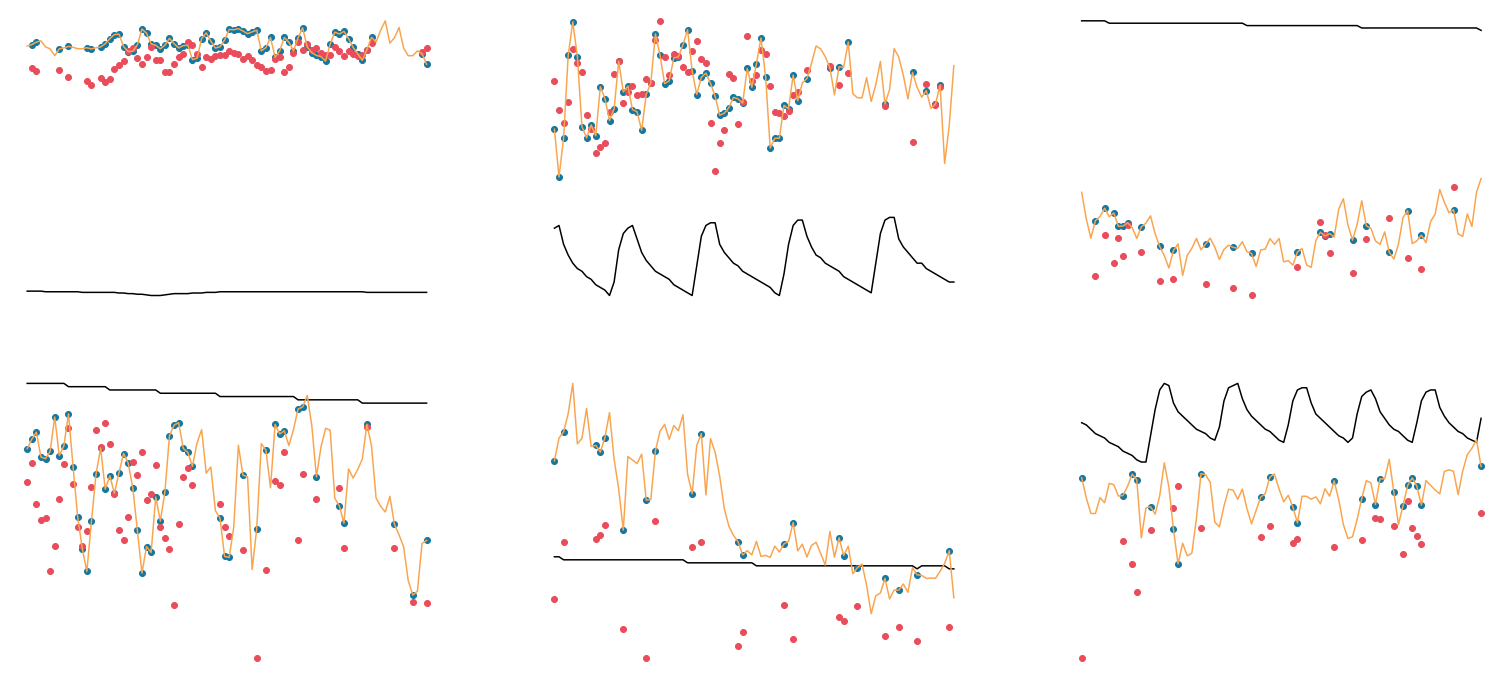

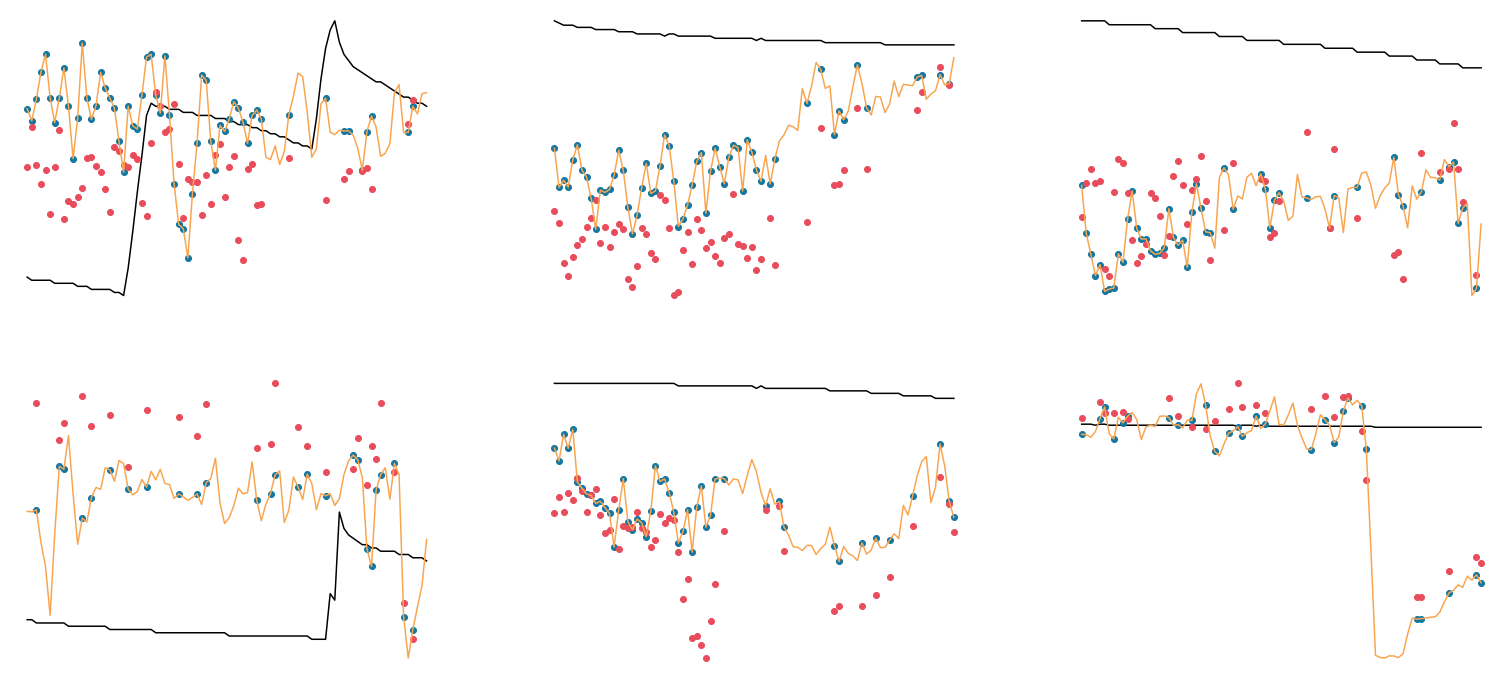

In [35]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (2):

        NUMBERS = np.arange(1, pred_result.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*8, (6/2.54)*8))
        
        i=-1
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, masked_pred[NUMBER, :, i], 'o', c=cmap[5], alpha=1) #estimated
            expect1 = plt.plot(x_t, masked_avg_pred[NUMBER, :, i], 'o', c=cmap[0], alpha=1) #estimated
            expect2 = plt.plot(x_t, pred_result[NUMBER, :, i], c=cmap[2], alpha=1) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1